In [1]:
# Essential and common packages
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import (Input, Add, Dense, Activation, 
                                     ZeroPadding2D, BatchNormalization, 
                                     Conv2D, AveragePooling2D, MaxPooling2D, 
                                     GlobalMaxPooling2D, Flatten)
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import confusion_matrix
import itertools

# For visualization of plots without plt.show()
%matplotlib inline

# Define the required variables
dataset_url = r'C:\Users\abudh\Desktop\CropWatch\EuroSAT\2750'
batch_size = 32
img_height = 64
img_width = 64
validation_split = 0.2
rescale = 1.0 / 255
epoch = 6

# Data preparation for the model
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_url,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
train_dataset = datagen.flow_from_directory(
    batch_size=batch_size,
    directory=dataset_url,
    shuffle=True,
    target_size=(img_height, img_width),
    subset="training",
    class_mode='categorical'
)
test_dataset = datagen.flow_from_directory(
    batch_size=batch_size,
    directory=dataset_url,
    shuffle=True,
    target_size=(img_height, img_width),
    subset="validation",
    class_mode='categorical'
)

# Visualization of input datasets
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

# ResNet50 Model building
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(filters=F1, kernel_size=1, strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X, training=training)
    return X

def convolutional_block(X, f, filters, s=2, training=True, initializer=glorot_uniform):
    F1, F2, F3 = filters
    X_shortcut = X
    X = Conv2D(filters=F1, kernel_size=1, strides=(s, s), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    X = Conv2D(F3, (1, 1), strides=(1, 1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), padding='valid', kernel_initializer=initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

def ResNet50(input_shape=(64, 64, 3), classes=10):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer=glorot_uniform(seed=0))(X)
    model = Model(inputs=X_input, outputs=X)
    return model

# Calculate class weights
class_weights = {}
for i, class_name in enumerate(train_dataset.class_indices):
    class_weights[i] = len(train_dataset.classes) / (len(train_dataset.class_indices) * np.bincount(train_dataset.classes)[i])

# Model train
model = ResNet50(input_shape=(64, 64, 3), classes=10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epoch,
    batch_size=batch_size,
    class_weight=class_weights
)

Found 27000 files belonging to 10 classes.
Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.
Epoch 1/6


C:\Users\abudh\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


675/675 ━━━━━━━━━━━━━━━━━━━━ 731s 1s/step - accuracy: 0.4302 - loss: 2.0339 - val_accuracy: 0.4917 - val_loss: 1.5132
Epoch 2/6
675/675 ━━━━━━━━━━━━━━━━━━━━ 600s 889ms/step - accuracy: 0.6044 - loss: 1.1415 - val_accuracy: 0.4198 - val_loss: 2.2015
Epoch 3/6
675/675 ━━━━━━━━━━━━━━━━━━━━ 597s 885ms/step - accuracy: 0.6508 - loss: 1.0457 - val_accuracy: 0.1111 - val_loss: 11077.9375
Epoch 4/6
675/675 ━━━━━━━━━━━━━━━━━━━━ 597s 884ms/step - accuracy: 0.6962 - loss: 0.8978 - val_accuracy: 0.7611 - val_loss: 0.6656
Epoch 5/6
675/675 ━━━━━━━━━━━━━━━━━━━━ 598s 885ms/step - accuracy: 0.7517 - loss: 0.7783 - val_accuracy: 0.7326 - val_loss: 1.0063
Epoch 6/6
675/675 ━━━━━━━━━━━━━━━━━━━━ 860s 1s/step - accuracy: 0.7678 - loss: 0.7020 - val_accuracy: 0.4996 - val_loss: 2.3363


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

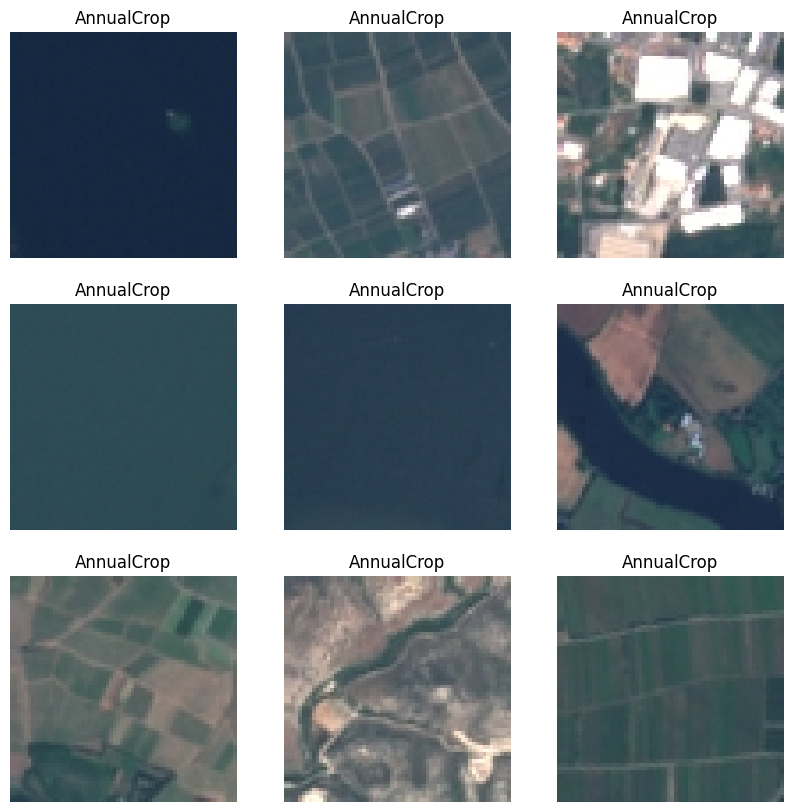

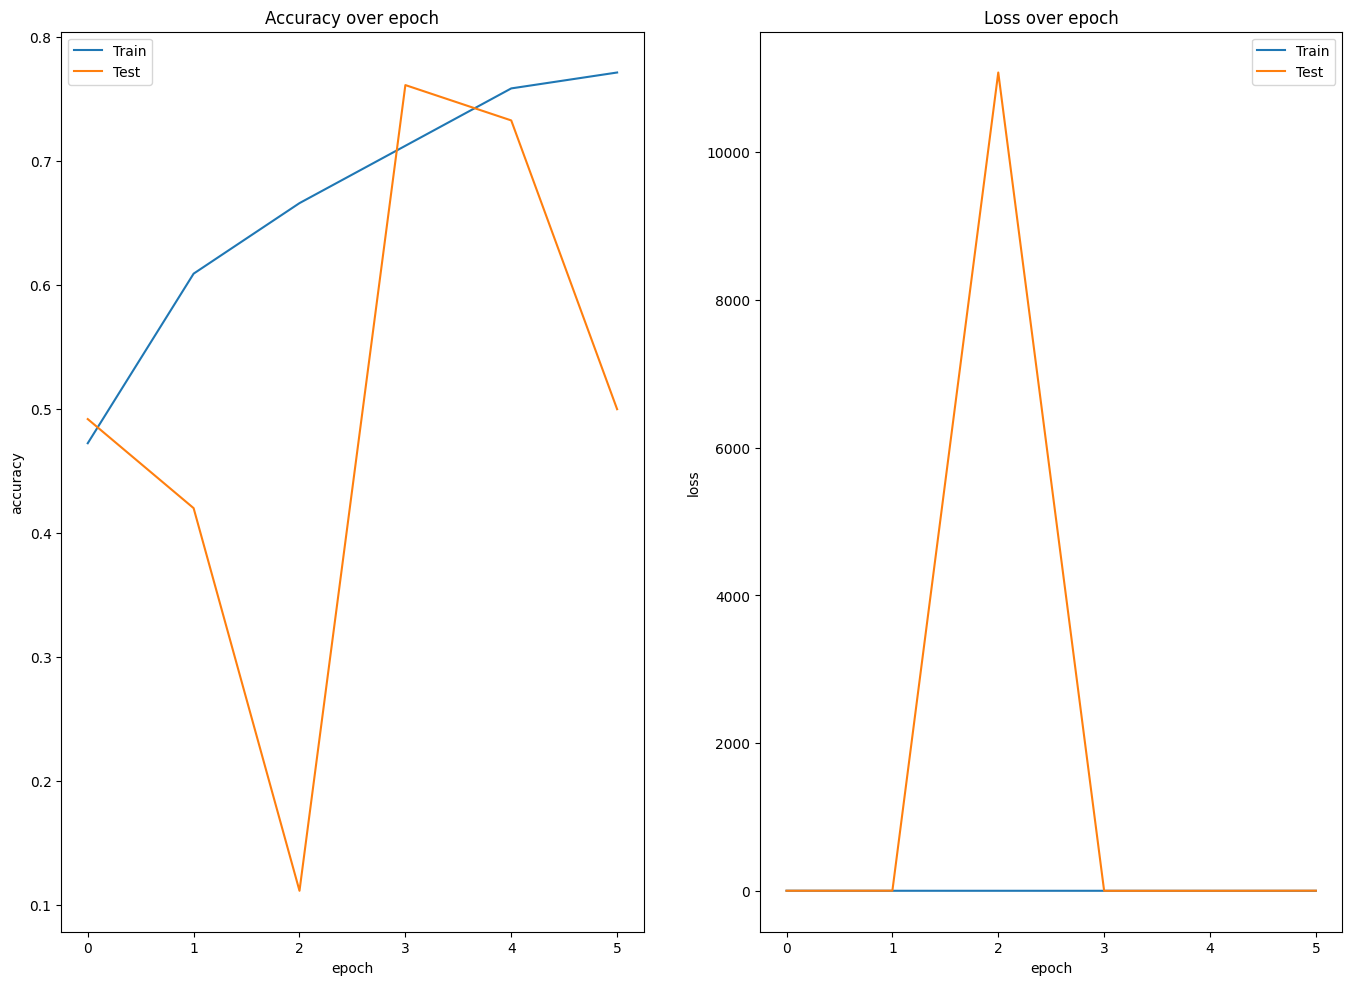

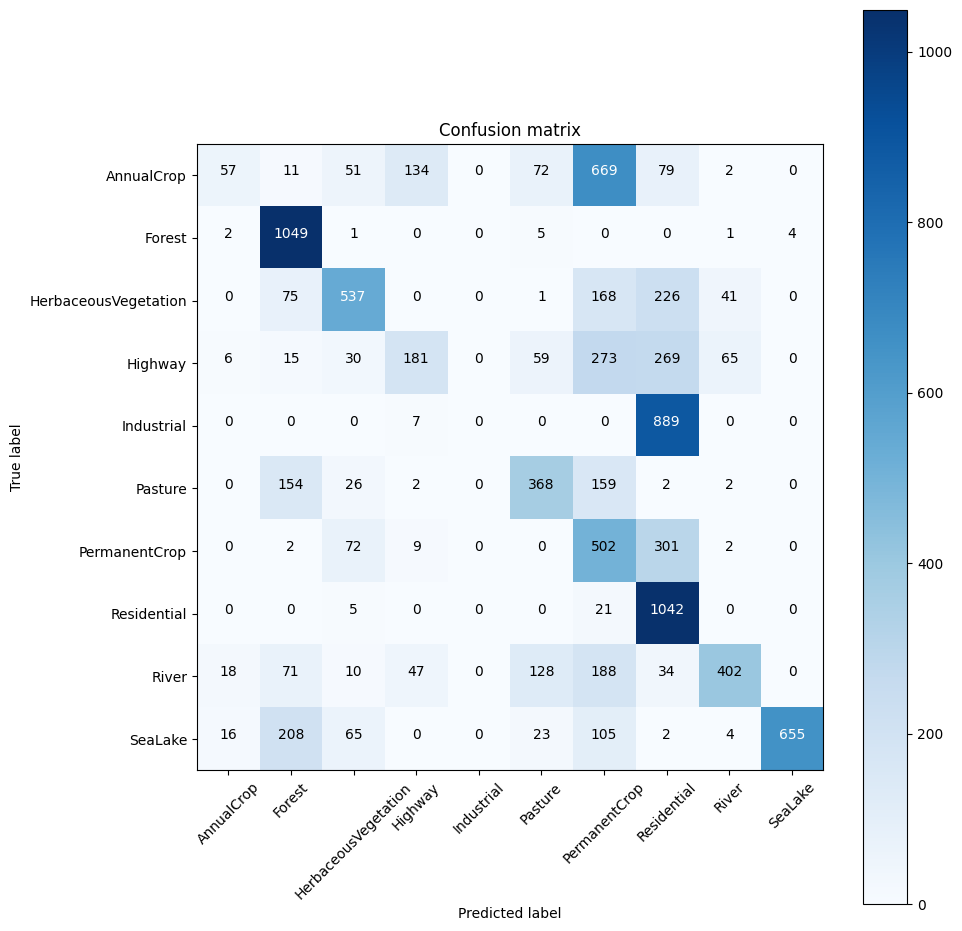

In [2]:


# Save the model
model.save('lulc_20_epoch.h5')

# Analyzing results and visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

# Confusion matrix
y_pred = []
y_true = []

for i, (image_batch, label_batch) in enumerate(test_dataset):
    y_true.append(label_batch)
    preds = model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis=1))
    if i == 300:
        break

correct_labels = tf.concat([item for item in y_true], axis=0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis=0)
cm = confusion_matrix(correct_labels, predicted_labels)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, classes=dataset.class_names)
plt.show()
